In [ ]:
import pandas as pd
from collections import Counter
import re
import seaborn as sbs
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")

In [ ]:
df_fake['Label']='Fake'
df_true['Label']='True'

In [ ]:
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

In [ ]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1

print(j)

21247


In [ ]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')

In [ ]:
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

In [ ]:
df_train= pd.concat([df_fake, df_true], axis=0)

In [ ]:
df_train.shape

(44877, 5)

In [ ]:
df_train=df_train.sample(frac=0.5)

In [ ]:
df_train.describe()

,title,text,subject,date,Label
count,22438,22438,22438,22438,22438
unique,20868,20703,8,2340,2
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017",Fake
freq,8,307,5636,96,11762


In [ ]:
df_train.head(5)

,title,text,subject,date,Label
11883,"Colombia names new peace negotiator with ELN, ...",BOGOTA (Reuters) - Colombia s President Juan M...,worldnews,"December 19, 2017",True
8922,This Incredibly Powerful Statement From A Tee...,"When we think of school shootings, we often th...",News,"January 6, 2016",Fake
4088,Donald Trump Jr. Says Bragging About Sexual A...,Donald Trump Jr. tried in vain to brush off hi...,News,"October 22, 2016",Fake
5056,"Trump talks infrastructure with Musk, developers",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"March 8, 2017",True
13529,WATCH: GEORGE W. BUSH Offers Somber Memorial H...,These two Presidents could not be more differe...,politics,"Jul 12, 2016",Fake


In [ ]:
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [ ]:
df_train.fillna('', inplace=True)

In [ ]:
df_train.duplicated().sum()

41

In [ ]:
df_train.drop_duplicates(inplace=True)

In [ ]:
df_train.duplicated().sum()

0

In [ ]:
df_train.reset_index(inplace=True)

In [ ]:
df_train

,index,title,text,subject,date,Label
0,11883,"Colombia names new peace negotiator with ELN, ...",BOGOTA (Reuters) - Colombia s President Juan M...,worldnews,"December 19, 2017",True
1,8922,This Incredibly Powerful Statement From A Tee...,"When we think of school shootings, we often th...",News,"January 6, 2016",Fake
2,4088,Donald Trump Jr. Says Bragging About Sexual A...,Donald Trump Jr. tried in vain to brush off hi...,News,"October 22, 2016",Fake
3,5056,"Trump talks infrastructure with Musk, developers",WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"March 8, 2017",True
4,13529,WATCH: GEORGE W. BUSH Offers Somber Memorial H...,These two Presidents could not be more differe...,politics,"Jul 12, 2016",Fake
...,...,...,...,...,...,...
22392,22721,"Digisexual Robot Pimps, Swamp Chess, Hollywood...",Tune in to the Alternate Current Radio Network...,Middle-east,"November 30, 2017",Fake
22393,18635,ABC Shuts Down Conservative Tim Allen’s “Last ...,Tim Allen s hit sitcom Last Man Standing has...,left-news,"May 13, 2017",Fake
22394,18316,Iran sentences member of nuclear negotiating t...,LONDON (Reuters) - Iranian authorities sentenc...,worldnews,"October 4, 2017",True
22395,8132,DNC Hilariously Matches Republican Voters Wit...,Are you a Republican? Are you tired of trying ...,News,"February 13, 2016",Fake


In [ ]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text

In [ ]:
df_train['text']=df_train['text'].apply(reuters_removal)

In [ ]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1

j

6

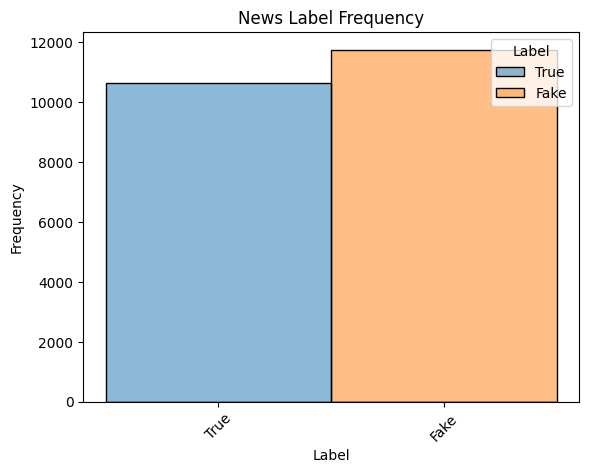

In [ ]:
sbs.histplot(x='Label', hue='Label',data=df_train)
plt.title('News Label Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency');

In [ ]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

subject
politicsNews       5624
worldnews          5011
News               4567
politics           3430
left-news          2212
Government News     762
Middle-east         402
US_News             389
Name: count, dtype: int64

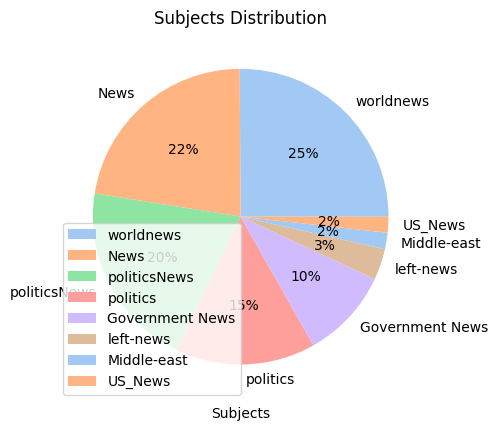

In [ ]:
colors = sbs.color_palette('pastel')[0:6]
plt.pie(df_top_group,labels=df_top.subject.unique(),autopct='%.0f%%', colors=colors)
plt.title('Subjects Distribution')
plt.xlabel('Subjects')
plt.legend(df_top.subject.unique(), loc='lower left')
plt.show();

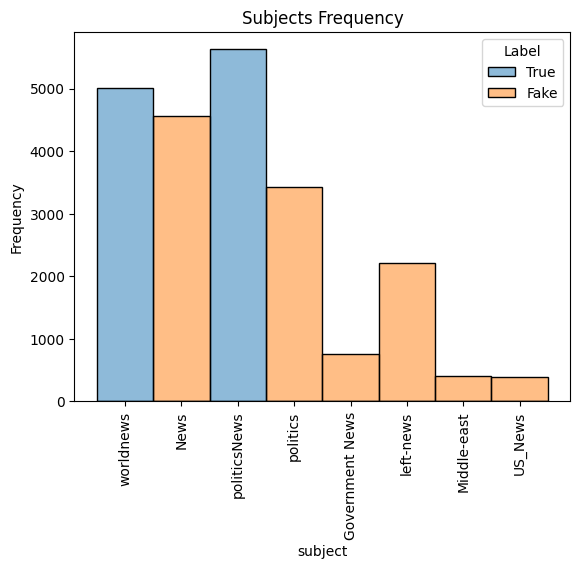

In [ ]:
top_parties = df_train['subject'].value_counts().nlargest(5).index
df_top=df_train.copy()
df_top.loc[~df_top['subject'].isin(top_parties), 'Party'] = 'Other'
sbs.histplot(x='subject', hue='Label', data=df_top, stat='count')
plt.title('Subjects Frequency')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show();

In [ ]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

In [ ]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)

In [ ]:
X

,title,text,subject
0,"Colombia names new peace negotiator with ELN, ...",BOGOTA - Colombia s President Juan Manuel Sant...,worldnews
1,This Incredibly Powerful Statement From A Tee...,"When we think of school shootings, we often th...",News
2,Donald Trump Jr. Says Bragging About Sexual A...,Donald Trump Jr. tried in vain to brush off hi...,News
3,"Trump talks infrastructure with Musk, developers",WASHINGTON - U.S. President Donald Trump met w...,politicsNews
4,WATCH: GEORGE W. BUSH Offers Somber Memorial H...,These two Presidents could not be more differe...,politics
...,...,...,...
22392,"Digisexual Robot Pimps, Swamp Chess, Hollywood...",Tune in to the Alternate Current Radio Network...,Middle-east
22393,ABC Shuts Down Conservative Tim Allen’s “Last ...,Tim Allen s hit sitcom Last Man Standing has s...,left-news
22394,Iran sentences member of nuclear negotiating t...,LONDON - Iranian authorities sentenced a membe...,worldnews
22395,DNC Hilariously Matches Republican Voters Wit...,Are you a Republican? Are you tired of trying ...,News


In [ ]:
y.unique()

array(['True', 'Fake'], dtype=object)

In [ ]:
port_stemmer= PorterStemmer()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def stemmer(content):
    stemmed_content=re.sub('[^a-zA-Z]',' ', content)
    stemmed_content= stemmed_content.lower()
    stemmed_content= stemmed_content.split()
    stemmed_content= [port_stemmer.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content= ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
X['text']= X['text'].apply(stemmer)

In [ ]:
X=X['text']

In [ ]:
X

0        bogota colombia presid juan manuel santo tuesd...
1        think school shoot often think directli involv...
2        donald trump jr tri vain brush dad boast abl s...
3        washington u presid donald trump met busi lead...
4        two presid could differ georg w bush natur bor...
                               ...                        
22392    tune altern current radio network acr anoth li...
22393    tim allen hit sitcom last man stand seen final...
22394    london iranian author sentenc member iran nucl...
22395    republican tire tri figur gop candid vote well...
22396    washington u justic depart said wednesday seek...
Name: text, Length: 22397, dtype: object

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=40, stratify=y)

In [ ]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

In [ ]:
xv_test

<4480x58012 sparse matrix of type '<class 'numpy.float64'>'
	with 667817 stored elements in Compressed Sparse Row format>

TRAINING MODEL


In [ ]:
rfc= RandomForestClassifier()

In [ ]:
rfc.fit(xv_train, y_train)

RandomForestClassifier()

In [ ]:
y_predicted = rfc.predict(xv_train)
rfc_accuracy = accuracy_score(y_predicted,y_train )

In [ ]:
rfc_accuracy

0.9999441870848914

In [ ]:
y_predicted = rfc.predict(xv_test)
rfc_accuracy = accuracy_score(y_predicted,y_test )

In [ ]:
rfc_accuracy

0.9720982142857143

In [ ]:
y_test.shape , y_predicted.shape

((4480,), (4480,))

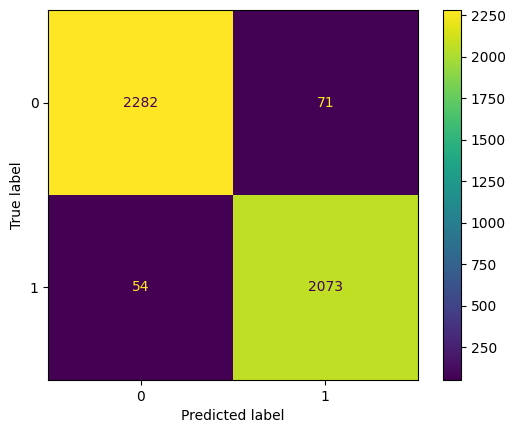

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.97      2353
        True       0.97      0.97      0.97      2127

    accuracy                           0.97      4480
   macro avg       0.97      0.97      0.97      4480
weighted avg       0.97      0.97      0.97      4480



In [ ]:
cm = confusion_matrix(y_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, y_predicted))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbm= GradientBoostingClassifier()
gbm.fit(xv_train, y_train)
y_predicted = gbm.predict(xv_test)
gbm_accuracy = accuracy_score(y_predicted,y_test )

In [ ]:
gbm_accuracy

0.9544642857142858

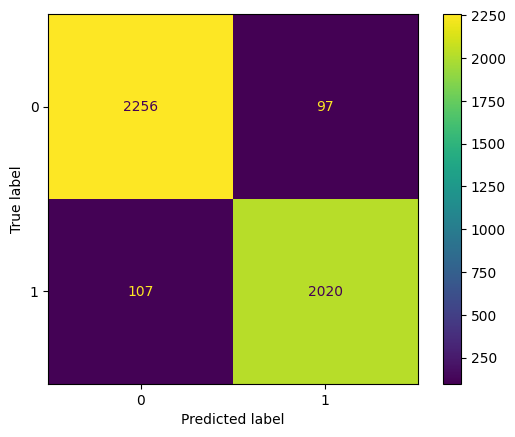

              precision    recall  f1-score   support

        Fake       0.95      0.96      0.96      2353
        True       0.95      0.95      0.95      2127

    accuracy                           0.95      4480
   macro avg       0.95      0.95      0.95      4480
weighted avg       0.95      0.95      0.95      4480



In [ ]:
cm = confusion_matrix(y_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, y_predicted))

Logistic Regression


In [ ]:
lgr=LogisticRegression(max_iter=1000)

In [ ]:
lgr.fit(xv_train,y_train)


LogisticRegression(max_iter=1000)

In [ ]:
y_pred=lgr.predict(xv_test)

In [ ]:
accuracy_score(y_pred,y_test)

0.9754464285714286

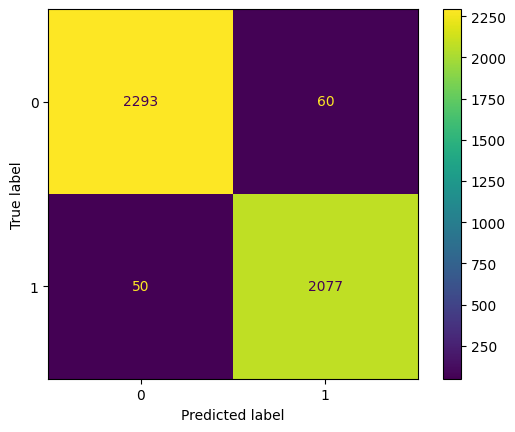

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      2353
        True       0.97      0.98      0.97      2127

    accuracy                           0.98      4480
   macro avg       0.98      0.98      0.98      4480
weighted avg       0.98      0.98      0.98      4480



In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
print(classification_report(y_test, y_pred))

Manual Testing

In [ ]:
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(reuters_removal)

    new_def_test["text"] = new_def_test["text"].apply(stemmer)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    prediction= rfc.predict(new_xv_test)
    return prediction[0]

In [ ]:
news_article = """
In an unprecedented move, a secret committee within the U.S. government has been revealed to be planning to dissolve the current Congress and hold new elections. According to leaked documents, this committee, led by high-ranking officials from both major political parties, aims to overhaul the legislative branch due to alleged widespread corruption and inefficiency.
The plan, codenamed "Operation Clean Sweep," suggests that all current members of Congress will be temporarily suspended, and a new election will be conducted within six months. The documents claim this drastic measure is necessary to restore public trust and ensure that only the most qualified and ethical candidates hold office.
This revelation has sparked a massive debate across the country, with many citizens expressing both support and outrage. Critics argue that this move undermines democracy and could lead to a dangerous concentration of power, while supporters believe it is a necessary step to combat corruption.
As the news spreads, the White House has neither confirmed nor denied the existence of such a plan, urging the public to remain calm and await official statements.
"""

In [ ]:
df_manual

,title,text,subject,date,Label
0,"Did Ron Paul Just Confuse Al-Qaeda With ISIS,...",Former Texas Congressman Ron Paul added yet mo...,News,"August 22, 2017",Fake
1,Congressional Black Caucus Signals That They ...,"The Congressional Black Caucus, like most Demo...",News,"August 21, 2017",Fake
2,Body-Slamming Republican Thought He Was Too I...,"You may remember Greg Gianforte, the Republica...",News,"August 21, 2017",Fake
3,Ron Paul Blames Obama For A Stock Market Cras...,"Ron Paul, who s a retired doctor, not an econo...",News,"August 21, 2017",Fake
4,GOP Lawmaker Blames Obama For Staging Racist ...,"According to Republican lawmaker from Idaho, i...",News,"August 21, 2017",Fake
5,Twitter Has Absolute Field Day Laughing At Tr...,Scientists have been warning the world for wee...,News,"August 21, 2017",Fake
6,Donald Trump Never Met A Disaster He Couldn’t...,Back when conservative politics were actually ...,News,"August 21, 2017",Fake
7,Thousands Of Advertisers Are Fleeing From Fak...,Donald Trump s former Chief Strategist Stephen...,News,"August 21, 2017",Fake
8,Trump’s Response To USS John S. McCain Collis...,It s common knowledge that Donald Trump is a s...,News,"August 21, 2017",Fake
9,Secret Service Officially Can’t Afford To Pay...,Donald Trump has been wasting taxpayer dollars...,News,"August 21, 2017",Fake


In [ ]:
for i in range(0,20):
  print(i)
  print(manual_testing(df_manual.loc[i,'text']))

0
Fake
1
Fake
2
Fake
3
Fake
4
Fake
5
Fake
6
Fake
7
Fake
8
Fake
9
Fake
10
True
11
True
12
True
13
True
14
True
15
True
16
True
17
True
18
True
19
True


Cross Validation

In [ ]:
X_str= vectorization.transform(X)

In [ ]:
st_kf= StratifiedKFold(n_splits=5)
st_score= cross_val_score(rfc, X_str, y, cv=st_kf )

In [ ]:
print("Cross Validation Scores: {}" .format(st_score))
print("Average Cross Validation Score: {}" .format(np.mean(st_score)))
print("Best Cross Validation Score: {}" .format(np.max(st_score)))
print("Worst Cross Validation Score: {}" .format(np.min(st_score)))

Cross Validation Scores: [0.97455357 0.97299107 0.97231525 0.9738781  0.97365483]
Average Cross Validation Score: 0.9734785646509106
Best Cross Validation Score: 0.9745535714285715
Worst Cross Validation Score: 0.9723152489394954


Saving the model

In [ ]:
y_final= y
X_final=X

In [ ]:
random_forest_pipeline = Pipeline([
        ('tfidf',TfidfVectorizer(ngram_range=(1,3),use_idf=True,smooth_idf=True)),
        ('rfc_model',RandomForestClassifier())
        ])

In [ ]:
random_forest_pipeline.fit(X_final, y_final)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('rfc_model', RandomForestClassifier())])